## Сверяем со старыми данными
этот раздел используется для проверки проведенных расчетов. Его не будет в финальной версии кода по данной модели.

In [32]:
from os import path, getcwd

import pandas as pd
import numpy as np
import sqlalchemy as sa
import re
import matplotlib.pyplot as plt

%store -r fdf #таблица результатов основной модели
%store -r Cond_df #таблица условий
%store -r HouseSqTot #Объем жилплощади на конец 2019 г.

In [33]:
tdf=pd.read_excel(r'../DB/SRC/Houses.xlsx') #старая БД из экселевской модели
tdf.replace(['Не заполнено','Нет данных','нет данных'], np.nan, inplace=True)

In [34]:
#создание пустого фрейма для результатов
w_cols=list(range(2015, 2036)) # задается период 2015 - 2035 гг.
fdf2=pd.DataFrame(columns=w_cols, index=Cond_df.index)

In [35]:
#применений условий к экселевским данным
for i, row in Cond_df.iterrows():
    d_main=row.to_dict()
    
    print(i,end='...')
    
    if pd.notna(d_main['age']):
        age=d_main['age']
        share=d_main['share']
        #print('age:',age,'share:',share)
        if pd.isna(d_main['floor_0']):
            d_body={k: d_main[k] for k in d_main if (pd.notna(d_main[k])) and k not in ['age', 'share']}
            query_age="(col-tdf['built_year']>={})".format(age)
            query_body = ' & '.join(['(tdf[{}]=={})'.format(repr(k),repr(v)) for k,v in d_body.items()])
            query=query_body+' & '+query_age
            #print(query)
        else:
            d_body={k: d_main[k] for k in d_main if pd.notna(d_main[k]) and k not in ['age','share','floor_0','floor_1']}
            d_floor={k: d_main[k] for k in ['floor_0','floor_1']}
            query_age="(col-tdf['built_year']>={})".format(age)
            query_body = ' & '.join(['(tdf[{}]=={})'.format(repr(k),repr(v)) for k,v in d_body.items()])
            query_floor = "(tdf['floor_count_max'].between({},{}))".format(d_floor['floor_0'],d_floor['floor_1'])
            query=query_body+' & '+query_floor+' & '+query_age
            d_body.update({'floor_count_max':'no matter'})
            #print(query)
    else:
        share=1
        d_body={k: d_main[k] for k in d_main if pd.notna(d_main[k])}
        query = ' & '.join(['(tdf[{}]=={})'.format(repr(k),repr(v)) for k,v in d_body.items()])
        #print(query)

    for col in fdf2.columns:
        fdf2.loc[i,col] = (tdf[eval(query)]['area_residential'].sum()/1000000) * HouseSqTot / (tdf.dropna(subset=d_body.keys())['area_residential'].sum()/1000000) * share
    print('Условие посчитано')    
    
fdf2.loc['Total']=fdf2.sum()

print('Итоговая таблица выбытий (суммарные выбытия в строке Total):')
fdf2

Деревянные...Условие посчитано
Панельные (1-5 этажей)...Условие посчитано
Смешанные...Условие посчитано
Иные...Условие посчитано
Блочные...Условие посчитано
Кирпичные (1-5 этажей)...Условие посчитано
Кирпичные (6+ этажей)...Условие посчитано
Панельные (6+ этажей)...Условие посчитано
Монолитные...Условие посчитано
Аварийные...Условие посчитано
Итоговая таблица выбытий (суммарные выбытия в строке Total):


,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,...,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035
Деревянные,9.82308,10.085,10.3453,10.6295,10.902,11.2097,11.4497,11.684,11.9121,12.1426,...,12.609,12.8278,13.0788,13.3302,13.6474,13.917,14.2342,14.603,14.9442,15.3335
Панельные (1-5 этажей),0.43265,0.517819,0.687624,1.03754,1.60077,3.0191,5.76268,10.1606,15.6967,22.2399,...,38.2162,46.7826,55.6743,64.4642,73.8324,82.8403,92.5075,102.18,111.812,121.18
Смешанные,0.404733,0.418484,0.464399,0.474051,0.488189,0.503253,0.509924,0.511536,0.512591,0.515354,...,0.562098,0.577934,0.622914,0.678205,0.780583,0.859047,1.01503,1.1373,1.27532,1.39435
Иные,1.2661,1.44228,1.65157,1.94994,2.27903,2.65011,3.07143,3.53844,4.01606,4.4044,...,5.05854,5.50047,6.19602,6.94111,7.5493,8.15676,8.93298,9.66519,10.3388,10.9994
Блочные,0.00930431,0.00930431,0.0210456,0.0215048,0.022025,0.0224662,0.0225035,0.0225035,0.0225035,0.0225691,...,0.0235516,0.0245464,0.0266239,0.0277856,0.0336021,0.0434746,0.0533813,0.0605797,0.0700298,0.082022
Кирпичные (1-5 этажей),0.466723,0.500008,1.23403,1.27219,1.2741,1.28395,1.28517,1.29045,1.299,1.3073,...,1.36172,1.42666,1.5388,1.69668,1.95071,2.15947,2.471,2.67634,2.92243,3.15599
Кирпичные (6+ этажей),0.0026749,0.00364622,0.00547214,0.00547214,0.00547214,0.00547214,0.00547214,0.00547214,0.00547214,0.00547214,...,0.00547214,0.0057922,0.0057922,0.0105633,0.0120405,0.0275871,0.0451289,0.0620736,0.0772891,0.0924116
Панельные (6+ этажей),0.0186963,0.0186963,0.0186963,0.0186963,0.0186963,0.0186963,0.0186963,0.0255588,0.0255588,0.0255588,...,0.0255588,0.0255588,0.0255588,0.0255588,0.0255588,0.0255588,0.0273549,0.032973,0.032973,0.034213
Монолитные,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Аварийные,25.012,25.012,25.012,25.012,25.012,25.012,25.012,25.012,25.012,25.012,...,25.012,25.012,25.012,25.012,25.012,25.012,25.012,25.012,25.012,25.012


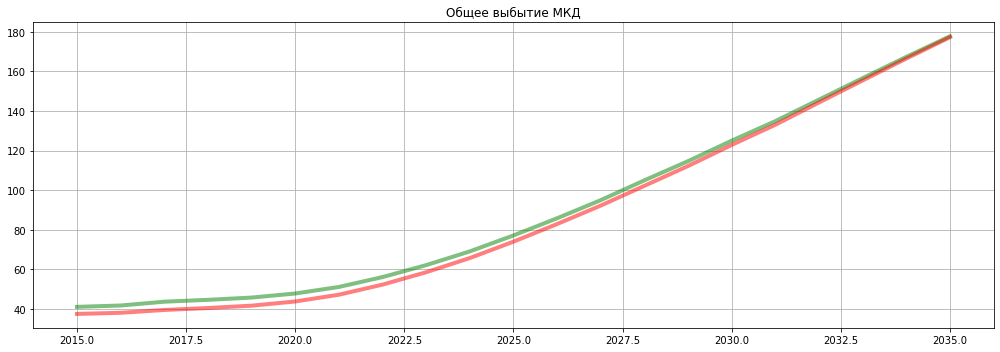

In [37]:
s   = fdf.loc['Total']
s2  = fdf2.loc['Total']
asa = s.plot.line(figsize=(14, 5), linewidth=4, alpha=0.5, title='Общее выбытие МКД', color='g')
bsa = s2.plot.line(ax=asa, linewidth=4, alpha=0.5, color='r', grid=True)
plt.tight_layout()
plt.show()